In [1]:
import os
os.chdir('..')

In [2]:
import detectron2_1

In [3]:
from detectron2.config import get_cfg
from pathlib import Path
from detectron2.engine import DefaultPredictor
import cv2
from detectron2.data import MetadataCatalog
from detectron2.utils.visualizer import Visualizer
from PIL import Image
import numpy as np
from detectron2_1.datasets import BenignMapper
from detectron2.data import DatasetMapper, MetadataCatalog, build_detection_test_loader
from detectron2.modeling import build_backbone, build_resnet_backbone, build_model


# Define Parameters here

In [4]:
img_path = 'data/samples/WechatIMG18.png'
cfg_path = 'output/rcnn_bet365/config.yaml'
weights_path = 'output/rcnn_bet365/model_final.pth'

conf_threshold = 0.05

# Inference

In [5]:
# Configure weights and confidence threshold
cfg = get_cfg()
cfg.merge_from_file(cfg_path)
cfg.MODEL.WEIGHTS = weights_path
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = conf_threshold

In [6]:
# Initialize model
predictor = DefaultPredictor(cfg)

In [7]:
predictor.transform_gen

ResizeShortestEdge(short_edge_length=[800, 800], max_size=1333)

In [8]:
import detectron2.data.transforms as T

In [61]:
with open('data/benign_data/coco_train.json', 'r') as json_file: 
    data = json.load(json_file) 

In [62]:
from detectron2.data import detection_utils as utils
import json
import copy
dataset_dict = copy.deepcopy(data)  # it will be modified by code below

In [63]:
# can use other ways to read image
image = utils.read_image(os.path.join('data/benign_data/benign_database', dataset_dict["images"][0]["file_name"]), format="BGR")

In [68]:
dataset_dict["annotations"][0]

{'area': 9384,
 'image_id': 0,
 'bbox': [725, 91, 276, 34],
 'category_id': 1,
 'id': 0,
 'iscrowd': 0}

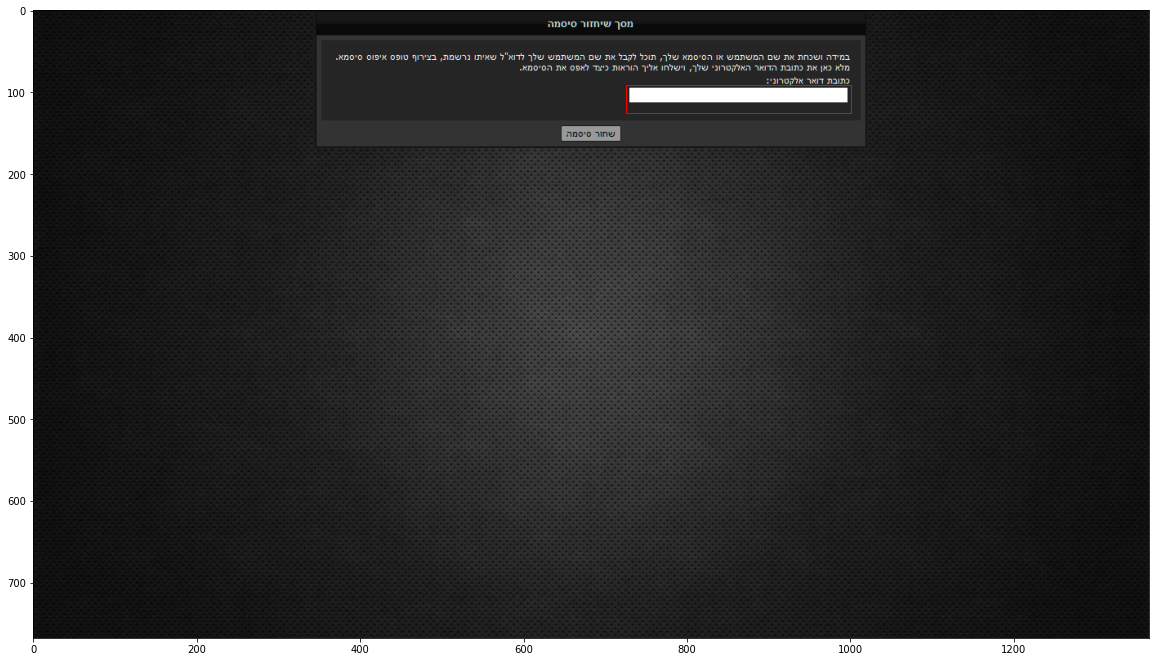

In [69]:
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
plt.figure(figsize=(20,20))
plt.imshow(image)
plt.gca().add_patch(Rectangle((725, 91), width=276, height=34, fill=False, linewidth=1,edgecolor='r'))
plt.show()

In [17]:
# See "Data Augmentation" tutorial for details usage
aug = T.ResizeShortestEdge(
            [cfg.INPUT.MIN_SIZE_TEST, cfg.INPUT.MIN_SIZE_TEST], cfg.INPUT.MAX_SIZE_TEST
        )

In [18]:
tf_image = image[:, :, ::-1]
height, width = tf_image.shape[:2]
tfms = aug.get_transform(tf_image)

In [19]:
tf_image = tfms.apply_image(tf_image)
trans_box = tfms.apply_box(np.array([299, 10, 228, 28]))[0].clip(min=0)

In [20]:
trans_box

array([222,   9, 291,  27])

In [28]:
print(image.shape)
print(tf_image.shape)

torch.Size([3, 749, 1333])
(749, 1333, 3)


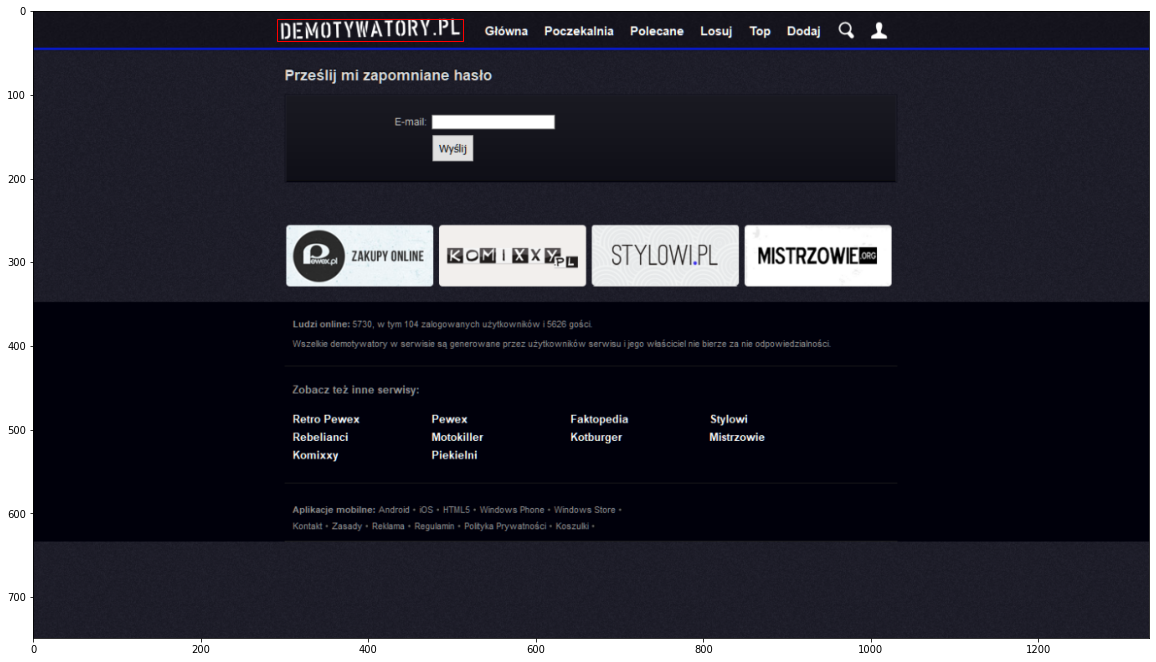

In [29]:
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
plt.figure(figsize=(20,20))
plt.imshow(tf_image[:, :, ::-1])
plt.gca().add_patch(Rectangle((trans_box[2], trans_box[1]), width=trans_box[0], height=trans_box[3], fill=False, linewidth=1,edgecolor='r'))
plt.show()

In [30]:
dataset_mapper = BenignMapper(cfg, is_train=False)
data_loader = build_detection_test_loader(
    cfg, cfg.DATASETS.TEST[0], mapper=dataset_mapper
)

In [31]:
import tqdm
for i, batch in enumerate(data_loader):
    image = batch[0]['image']
    height, width = batch[0]['instances'].image_size
    inputs = {"image": image, "height": height, "width": width}
    break

In [54]:
dataset_mapper = BenignMapper(cfg, is_train=False)
data_loader = build_detection_test_loader(
    cfg, 'benign_train', mapper=dataset_mapper
)

In [56]:
len(data_loader)

29073

In [32]:
batch

[{'file_name': 'data/benign_data/benign_database/demotywatory.pl/shot.png',
  'height': 768,
  'width': 1366,
  'image_id': 0,
  'image': tensor([[[23, 24, 24,  ..., 23, 23, 23],
           [22, 23, 23,  ..., 22, 23, 24],
           [21, 21, 21,  ..., 21, 23, 24],
           ...,
           [25, 25, 29,  ..., 30, 30, 26],
           [25, 33, 26,  ..., 29, 27, 25],
           [25, 31, 30,  ..., 32, 31, 30]],
  
          [[22, 23, 23,  ..., 22, 22, 22],
           [21, 22, 22,  ..., 21, 22, 23],
           [20, 20, 20,  ..., 20, 22, 23],
           ...,
           [25, 25, 28,  ..., 29, 29, 26],
           [25, 33, 26,  ..., 28, 27, 25],
           [25, 30, 29,  ..., 31, 30, 29]],
  
          [[31, 32, 32,  ..., 31, 31, 31],
           [30, 31, 31,  ..., 30, 31, 32],
           [29, 29, 29,  ..., 29, 31, 32],
           ...,
           [36, 36, 40,  ..., 41, 41, 37],
           [36, 44, 37,  ..., 40, 38, 36],
           [36, 42, 41,  ..., 43, 42, 41]]], dtype=torch.uint8),
  'instances

In [33]:
model = build_model(cfg)
model.eval()

GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res2): Sequential(
        (0): BottleneckBlock

In [34]:
check = model.preprocess_image([inputs])

In [35]:
check.image_sizes

[(749, 1333)]

In [36]:
check.tensor

tensor([[[[-80.5300, -79.5300, -79.5300,  ...,   0.0000,   0.0000,   0.0000],
          [-81.5300, -80.5300, -80.5300,  ...,   0.0000,   0.0000,   0.0000],
          [-82.5300, -82.5300, -82.5300,  ...,   0.0000,   0.0000,   0.0000],
          ...,
          [  0.0000,   0.0000,   0.0000,  ...,   0.0000,   0.0000,   0.0000],
          [  0.0000,   0.0000,   0.0000,  ...,   0.0000,   0.0000,   0.0000],
          [  0.0000,   0.0000,   0.0000,  ...,   0.0000,   0.0000,   0.0000]],

         [[-94.2800, -93.2800, -93.2800,  ...,   0.0000,   0.0000,   0.0000],
          [-95.2800, -94.2800, -94.2800,  ...,   0.0000,   0.0000,   0.0000],
          [-96.2800, -96.2800, -96.2800,  ...,   0.0000,   0.0000,   0.0000],
          ...,
          [  0.0000,   0.0000,   0.0000,  ...,   0.0000,   0.0000,   0.0000],
          [  0.0000,   0.0000,   0.0000,  ...,   0.0000,   0.0000,   0.0000],
          [  0.0000,   0.0000,   0.0000,  ...,   0.0000,   0.0000,   0.0000]],

         [[-92.6750, -91.6750,

In [37]:
check.tensor.shape

torch.Size([1, 3, 768, 1344])

In [166]:
check[0]

tensor([[[-80.5300, -79.5300, -79.5300,  ..., -80.5300, -80.5300, -80.5300],
         [-81.5300, -80.5300, -80.5300,  ..., -81.5300, -80.5300, -79.5300],
         [-82.5300, -82.5300, -82.5300,  ..., -82.5300, -80.5300, -79.5300],
         ...,
         [-78.5300, -78.5300, -74.5300,  ..., -73.5300, -73.5300, -77.5300],
         [-78.5300, -70.5300, -77.5300,  ..., -74.5300, -76.5300, -78.5300],
         [-78.5300, -72.5300, -73.5300,  ..., -71.5300, -72.5300, -73.5300]],

        [[-94.2800, -93.2800, -93.2800,  ..., -94.2800, -94.2800, -94.2800],
         [-95.2800, -94.2800, -94.2800,  ..., -95.2800, -94.2800, -93.2800],
         [-96.2800, -96.2800, -96.2800,  ..., -96.2800, -94.2800, -93.2800],
         ...,
         [-91.2800, -91.2800, -88.2800,  ..., -87.2800, -87.2800, -90.2800],
         [-91.2800, -83.2800, -90.2800,  ..., -88.2800, -89.2800, -91.2800],
         [-91.2800, -86.2800, -87.2800,  ..., -85.2800, -86.2800, -87.2800]],

        [[-92.6750, -91.6750, -91.6750,  ...

In [26]:
for b in batch[0]['instances'].gt_classes:
    print(b.item())

1
0


In [39]:
cv2.imread('data/benign_data/benign_database/demotywatory.pl/shot_adv.png').shape

(768, 1344, 3)

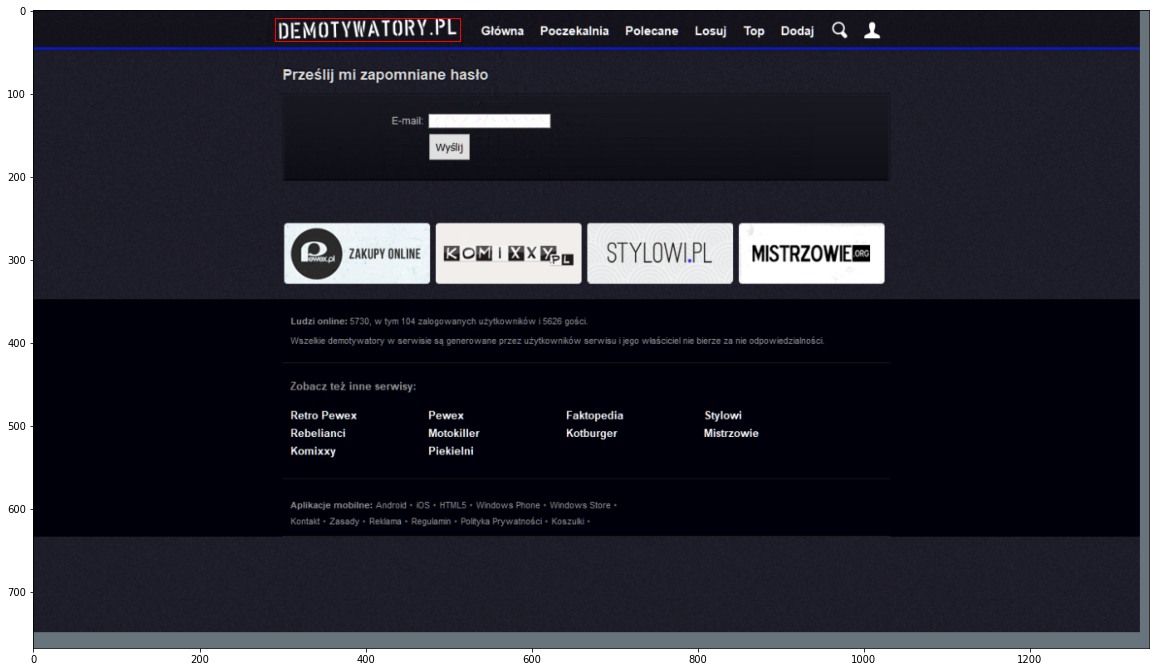

In [38]:
plt.figure(figsize=(20,20))
plt.imshow(cv2.imread('data/benign_data/benign_database/demotywatory.pl/shot_adv.png'))
plt.gca().add_patch(Rectangle((291, 9), width=223, height=28, fill=False, linewidth=1,edgecolor='r'))

More info on output format: https://detectron2.readthedocs.io/tutorials/models.html#model-output-format

# Visualization

In [51]:
# Set dataset categories
dataset = cfg.DATASETS.TRAIN[0]
MetadataCatalog.get(dataset).thing_classes = ["box", "logo"]

In [52]:
MetadataCatalog.get(dataset)

Metadata(evaluator_type='coco', image_root=PosixPath('data/benign_data/benign_database'), json_file=PosixPath('data/benign_data/coco_train.json'), name='benign_train', thing_classes=['box', 'logo'])

'benign_train'

In [32]:
# Draw instance predictions
v = Visualizer(im[:, :, ::-1], MetadataCatalog.get(dataset))
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))

In [33]:
# Image with instance predictions as numpy array
pred = out.get_image()

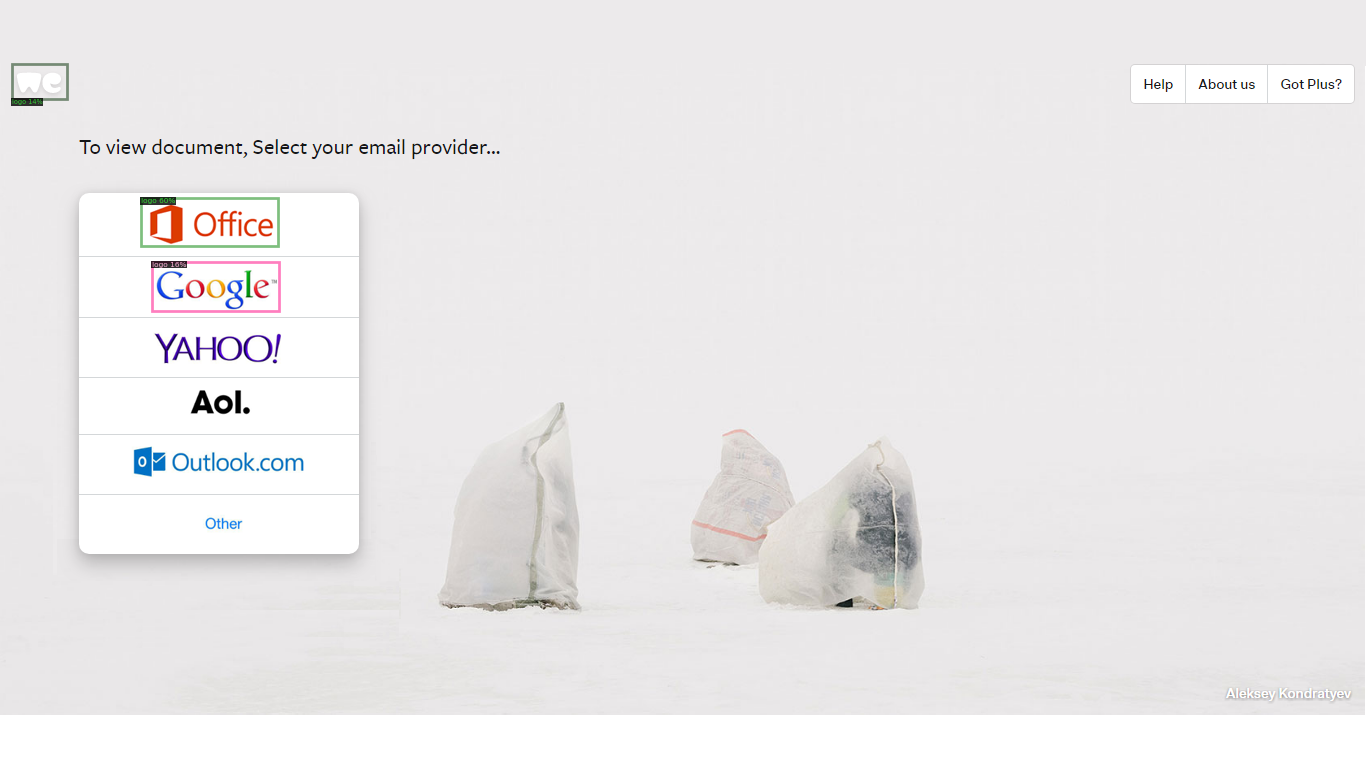

In [34]:
Image.fromarray(pred)

# Inference on Set of Images


In [5]:
from pathlib import Path
from inference import inference

In [6]:
imgs_dir = Path('data')/'bet365'
config_path = 'output/rcnn_2/config.yaml'
weights_path = 'output/rcnn_bet365/model_final.pth'
output_dir = Path('saved')/'bet365'

conf_threshold = 0.05

In [7]:
for i, img_path in enumerate(imgs_dir.rglob('*.png')):
    output_path = str(output_dir/f'{i}.png')

    inference(
        str(img_path),
        config_path,
        weights_path,
        output_path,
        conf_threshold
    )

    print(f'Saved to {output_path}')

Saved to saved/bet365/0.png
Saved to saved/bet365/1.png
Saved to saved/bet365/2.png
Saved to saved/bet365/3.png
Saved to saved/bet365/4.png
Saved to saved/bet365/5.png
Saved to saved/bet365/6.png
Saved to saved/bet365/7.png
Saved to saved/bet365/8.png
Saved to saved/bet365/9.png
Saved to saved/bet365/10.png
Saved to saved/bet365/11.png
Saved to saved/bet365/12.png
Saved to saved/bet365/13.png
Saved to saved/bet365/14.png
Saved to saved/bet365/15.png
Saved to saved/bet365/16.png
Saved to saved/bet365/17.png
Saved to saved/bet365/18.png
Saved to saved/bet365/19.png
Saved to saved/bet365/20.png
Saved to saved/bet365/21.png
Saved to saved/bet365/22.png
Saved to saved/bet365/23.png
Saved to saved/bet365/24.png
Saved to saved/bet365/25.png
Saved to saved/bet365/26.png
Saved to saved/bet365/27.png
Saved to saved/bet365/28.png
Saved to saved/bet365/29.png
Saved to saved/bet365/30.png
Saved to saved/bet365/31.png
Saved to saved/bet365/32.png
Saved to saved/bet365/33.png
Saved to saved/bet365/34

## COCO data format

In [180]:
json_dict = {"images": [], "type": "instances", "annotations": [], "categories": []}

In [ ]:
## The filename must be a number
width = int(get_and_check(size, "width", 1).text)
height = int(get_and_check(size, "height", 1).text)
image = {
    "file_name": filename,
    "height": height,
    "width": width,
    "id": image_id,
}
json_dict["images"].append(image)

category_id = categories[category]
bndbox = get_and_check(obj, "bndbox", 1)
xmin = int(get_and_check(bndbox, "xmin", 1).text) - 1
ymin = int(get_and_check(bndbox, "ymin", 1).text) - 1
xmax = int(get_and_check(bndbox, "xmax", 1).text)
ymax = int(get_and_check(bndbox, "ymax", 1).text)
assert xmax > xmin
assert ymax > ymin
o_width = abs(xmax - xmin)
o_height = abs(ymax - ymin)
ann = {
    "area": o_width * o_height,
    "iscrowd": 0,
    "image_id": image_id,
    "bbox": [xmin, ymin, o_width, o_height],
    "category_id": category_id,
    "id": bnd_id,
    "ignore": 0,
    "segmentation": [],
}
json_dict["annotations"].append(ann)

In [190]:
with open('data/benign_data/coco_test.json', 'r') as haha:
    kk = json.load(haha)

In [191]:
kk['annotations'][-1]['id']

3747

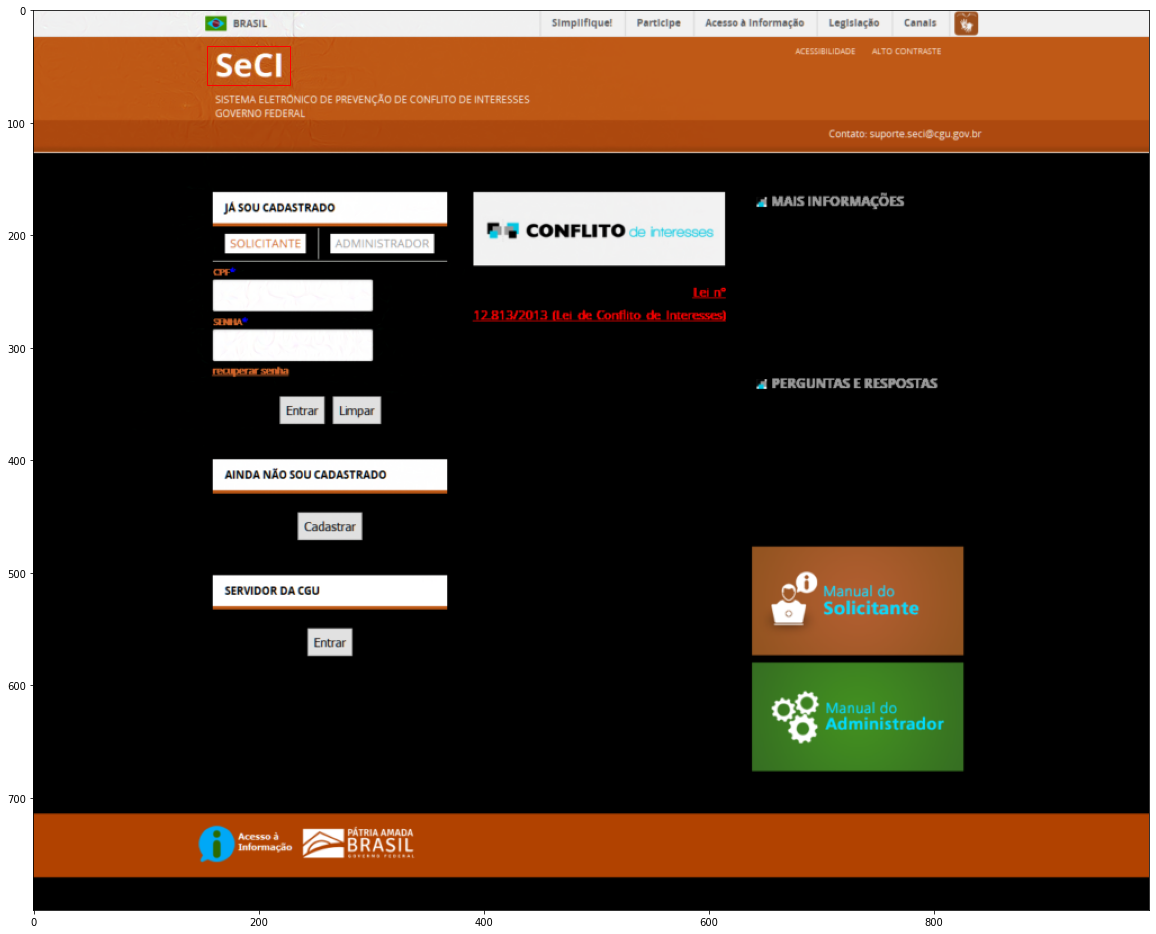

In [59]:
plt.figure(figsize=(20,20))
plt.imshow(cv2.imread('data/benign_data/benign_database/ufms.br/shot_adv.png'))
plt.gca().add_patch(Rectangle((154, 32), width=74, height=34, fill=False, linewidth=1,edgecolor='r'))

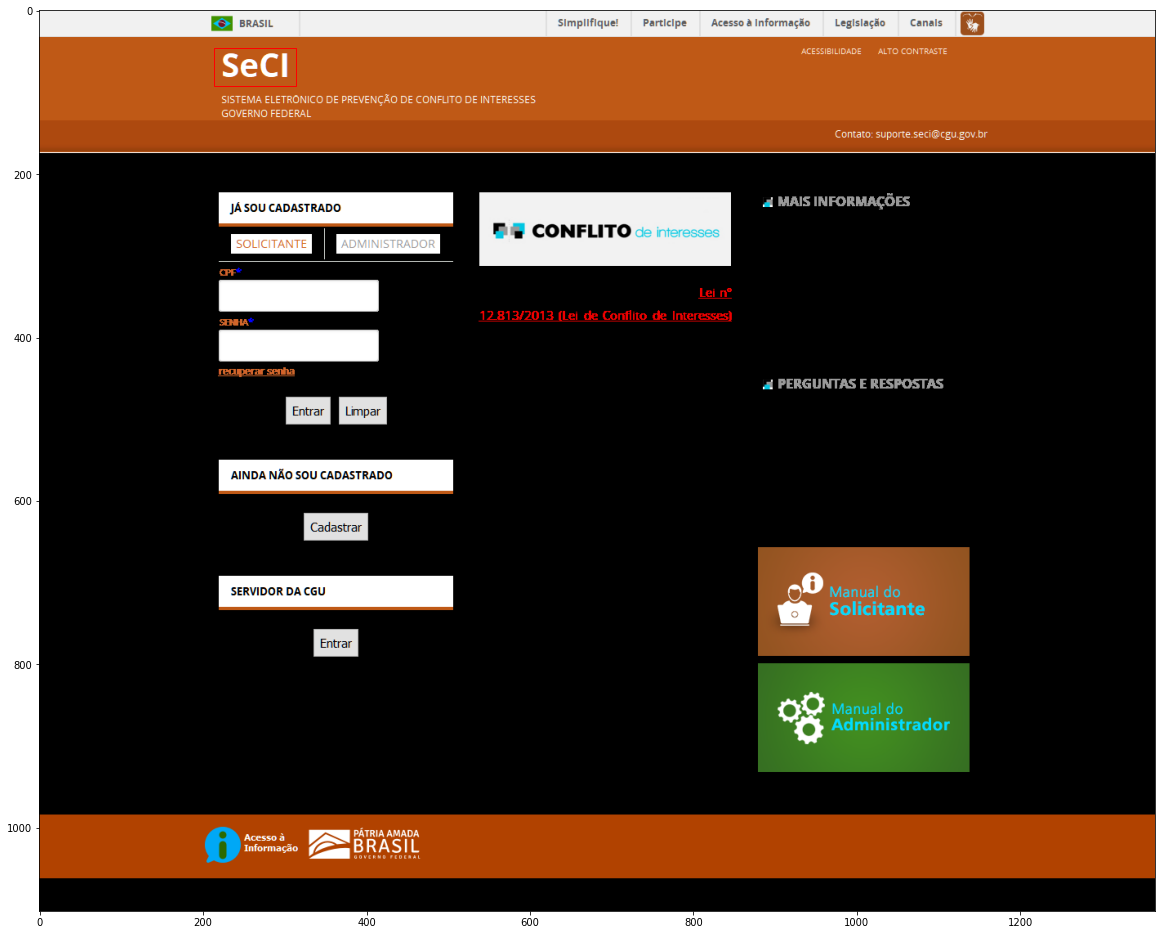

In [60]:
plt.figure(figsize=(20,20))
plt.imshow(cv2.imread('data/benign_data/benign_database/ufms.br/shot.png'))
plt.gca().add_patch(Rectangle((213, 45), width=101, height=47, fill=False, linewidth=1,edgecolor='r'))